# 逻辑回归实现鸢尾花二分类

本实验主要介绍使用MindSpore在2分类数据集上进行逻辑回归实验，分析自变量和因变量（概率）之间的关系，即求得一个概率函数。

## 1、实验目的

- 了解逻辑回归的基本概念；
- 了解如何使用MindSpore进行逻辑回归实验。

## 2、逻辑回归算法原理
逻辑回归（Logistic Regression）是机器学习最经典的算法之一，1838年由比利时学者Verhulst首次提出；1920年美国学者Bearl & Reed在研究果蝇的繁殖中发现和使用该函数，并在人口估计和预测中推广使用。与线性回归有很多不同，这两种回归都属于广义线性回归（Generalized Linear Regression）的范畴。但逻辑回归具有如下特点：

逻辑回归对自变量分布没有要求；
因变量是离散型变量，即分类变量；
逻辑回归分析的是因变量取某个值的概率与自变量的关系。

逻辑回归的假设函数为：

$$h_{\theta}(X) = g(X\theta) = \frac{ 1 }{ 1 + e^{-X\theta} }$$

式中$X$为样本输入，$h_{\theta}(X)$为模型的输出，${\theta}$为需要求解的模型参数。

其函数曲线如下：

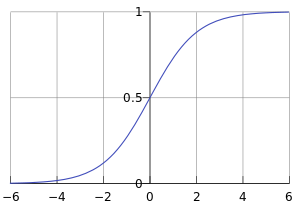

若假设0.5为临界值，当$h_{\theta}(X)$>0.5时，即$X$>0时，$y$的取值范围为[0.5,1]；当$h_{\theta}(X)$<0.5时，即$X$<0时，$y$的取值范围为[0,0.5];由上图可知，模型输出值$h_{\theta}(X)$在[0,1]之间。因此，从概率的角度分析为：当$h_{\theta}(X)$越接近于0，某样本属于0类的概率越高；当$h_{\theta}(X)$越接近于1，某样本属于1类的概率越高；当$h_{\theta}(X)$越接近于临界值0.5，则无法判断样本类别。

## 3、实验环境

预备知识：

- 熟练使用Python。
- 具备一定的机器学习理论知识，如逻辑回归、损失函数、优化器，训练策略等。

实验环境：

- MindSpore 2.0（MindSpore版本会定期更新，本指导也会定期刷新，与版本配套）；
- 本案例支持win_x86和Linux系统，CPU/GPU/Ascend均可运行。
- 如果在本地运行此实验，请参考《MindSpore环境搭建实验手册》在本地安装MindSpore。

## 4.1、数据处理

### 4.1 数据准备
#### 下载数据
Iris数据集是模式识别最著名的数据集之一。数据集包含3类，每类50个实例，其中每个类都涉及一种鸢尾植物。 第一类与后两类可线性分离，后两类之间不能线性分离，所以本实验取前两类数据，做一个2分类数据集。  
  Iris数据集的官网：[Iris Data Set](http://archive.ics.uci.edu/ml/datasets/Iris)。  
方式一，从Iris数据集官网下载[iris.data文件](http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data)。  
方式二，从华为云OBS中下载[iris.data文件](https://ascend-professional-construction-dataset.obs.cn-north-4.myhuaweicloud.com:443/MachineLearning/iris.zip)。

每个样本含有4个数值属性和一个类别属性：
1. sepal length in cm
2. sepal width in cm
3. petal length in cm
4. petal width in cm
5. class: 
    - Iris Setosa
    - Iris Versicolour
    - Iris Virginica

概括统计：

                 Min  Max   Mean    SD   Class Correlation
   sepal length: 4.3  7.9   5.84  0.83    0.7826   
    sepal width: 2.0  4.4   3.05  0.43   -0.4194
   petal length: 1.0  6.9   3.76  1.76    0.9490  (high!)
    petal width: 0.1  2.5   1.20  0.76    0.9565  (high!)

In [1]:
from download import download

# 下载Iris数据集
url = "https://ascend-professional-construction-dataset.obs.cn-north-4.myhuaweicloud.com:443/MachineLearning/iris.zip"  
path = download(url, "./", kind="zip", replace=True)


file_sizes: 100%|███████████████████████████████| 963/963 [00:00<00:00, 242kB/s]
Extracting zip file...
Successfully downloaded / unzipped to ./


### 4.2 数据读取与处理
#### 导入MindSpore模块和辅助模块


In [2]:
%matplotlib inline
import os
import csv
import numpy as np

import mindspore as ms
from mindspore import nn, context, ms_function, dataset
from mindspore.train import LossMonitor
from mindspore.ops import SigmoidCrossEntropyWithLogits, ReduceMean

context.set_context(mode=context.GRAPH_MODE, device_target="CPU")

#### 读取Iris数据集，并查看部分数据

In [3]:
with open('iris.data') as csv_file:
    data = list(csv.reader(csv_file, delimiter=','))
print(data[40:60])

[['5.0', '3.5', '1.3', '0.3', 'Iris-setosa'], ['4.5', '2.3', '1.3', '0.3', 'Iris-setosa'], ['4.4', '3.2', '1.3', '0.2', 'Iris-setosa'], ['5.0', '3.5', '1.6', '0.6', 'Iris-setosa'], ['5.1', '3.8', '1.9', '0.4', 'Iris-setosa'], ['4.8', '3.0', '1.4', '0.3', 'Iris-setosa'], ['5.1', '3.8', '1.6', '0.2', 'Iris-setosa'], ['4.6', '3.2', '1.4', '0.2', 'Iris-setosa'], ['5.3', '3.7', '1.5', '0.2', 'Iris-setosa'], ['5.0', '3.3', '1.4', '0.2', 'Iris-setosa'], ['7.0', '3.2', '4.7', '1.4', 'Iris-versicolor'], ['6.4', '3.2', '4.5', '1.5', 'Iris-versicolor'], ['6.9', '3.1', '4.9', '1.5', 'Iris-versicolor'], ['5.5', '2.3', '4.0', '1.3', 'Iris-versicolor'], ['6.5', '2.8', '4.6', '1.5', 'Iris-versicolor'], ['5.7', '2.8', '4.5', '1.3', 'Iris-versicolor'], ['6.3', '3.3', '4.7', '1.6', 'Iris-versicolor'], ['4.9', '2.4', '3.3', '1.0', 'Iris-versicolor'], ['6.6', '2.9', '4.6', '1.3', 'Iris-versicolor'], ['5.2', '2.7', '3.9', '1.4', 'Iris-versicolor']]


#### 抽取样本
取前两类样本（共100条），将数据集的4个属性作为自变量X。将数据集的2个类别映射为{0, 1}，作为因变量Y。


In [4]:
label_map = {
    'Iris-setosa': 0,
    'Iris-versicolor': 1,
}

X = np.array([[float(x) for x in s[:-1]] for s in data[:100]], np.float32)
Y = np.array([[label_map[s[-1]]] for s in data[:100]], np.float32)

#### 样本可视化
取样本的前两个属性进行2维可视化，可以看到在前两个属性上两类样本是线性可分的。


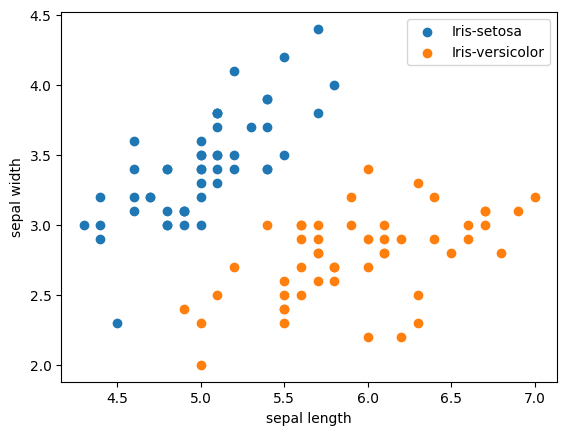

In [5]:
from matplotlib import pyplot as plt
plt.scatter(X[:50, 0], X[:50, 1], label='Iris-setosa')
plt.scatter(X[50:, 0], X[50:, 1], label='Iris-versicolor')
plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.legend()

#### 分割数据集
将数据集按8:2划分为训练集和验证集：


In [6]:
train_idx = np.random.choice(100, 80, replace=False)
test_idx = np.array(list(set(range(100)) - set(train_idx)))
X_train, Y_train = X[train_idx], Y[train_idx]
X_test, Y_test = X[test_idx], Y[test_idx]

#### 数据类型转换
使用MindSpore的GeneratorDataset接口将numpy.ndarray类型的数据转换为Dataset：


In [7]:
XY_train = list(zip(X_train, Y_train))
ds_train = dataset.GeneratorDataset(XY_train, ['x', 'y'], shuffle=True)
ds_train = ds_train.batch(32, drop_remainder=True)

## 5、 模型搭建
#### 可视化逻辑回归函数

逻辑回归常用的联系函数是Sigmoid（S形函数），Sigmoid函数如下图所示，可以将连续值映射到{0, 1}，同时也是单调可微的。

Text(0, 0.5, 'p')

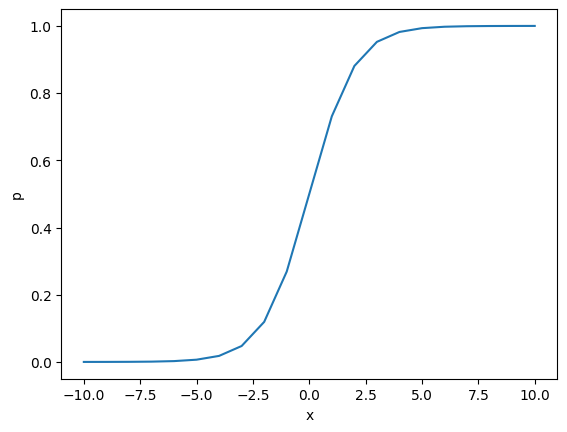

In [8]:
coor_x = np.arange(-10, 11, dtype=np.float32)
coor_y = nn.Sigmoid()(ms.Tensor(coor_x)).asnumpy()
plt.plot(coor_x, coor_y)
plt.xlabel('x')
plt.ylabel('p')

####  建模
使用MindSpore提供的[`nn.Dense(4, 1)`算子](https://www.mindspore.cn/docs/zh-CN/r2.0.0-alpha/api_python/nn/mindspore.nn.Dense.html?highlight=dense)作为线性部分，其中`(4, 1)`表示每个样本的输入是含4个元素的向量，输出是含1个元素的向量，即$W$是1x4的矩阵。算子会随机初始化权重$W$和偏置$b$。使用[`SigmoidCrossEntropyWithLogits`算子](https://www.mindspore.cn/docs/zh-CN/r2.0.0-alpha/api_python/ops/mindspore.ops.SigmoidCrossEntropyWithLogits.html?highlight=sigmoidcrossentropywithlogits)作为非线性部分：

对于每个样本$N_i$，模型的计算方式如下：

$$
Z_i = W \cdot X_i + b \\
P_{i} = sigmoid(Z_{i}) = \frac{1}{1 + e^{-Z_{i}}} \\
loss = -\frac{1}n\sum_i[Y_{i} * ln(P_{i}) + (1 - Y_{i})ln(1 - P_{i})]
$$

其中，$X_i$是1D Tensor（含4个元素），$Z_i$是1D Tensor（含1个元素），$Y_i$是真实类别（2个类别{0, 1}中的一个），$P_i$是1D Tensor（含1个元素，表示属于类别1的概率，值域为[0, 1]），$loss$是标量。


In [9]:
# 自定义Loss
class Loss(nn.Cell):
    def __init__(self):
        super(Loss, self).__init__()
        self.sigmoid_cross_entropy_with_logits = SigmoidCrossEntropyWithLogits()
        self.reduce_mean = ReduceMean(keep_dims=False)
    def construct(self, x, y):
        loss = self.sigmoid_cross_entropy_with_logits(x, y)
        return self.reduce_mean(loss, -1)

net = nn.Dense(4, 1)
loss = Loss()
opt = nn.SGD(net.trainable_params(), learning_rate=0.003)

## 6、模型训练
使用2分类的Iris数据集对模型进行几代（Epoch）训练

In [10]:
model = ms.train.Model(net, loss, opt)
model.train(5, ds_train, callbacks=[LossMonitor(per_print_times=ds_train.get_dataset_size())], dataset_sink_mode=False)

epoch: 1 step: 2, loss is 0.6520217061042786
epoch: 2 step: 2, loss is 0.576836884021759
epoch: 3 step: 2, loss is 0.5104101896286011
epoch: 4 step: 2, loss is 0.46707332134246826
epoch: 5 step: 2, loss is 0.41439753770828247


## 7、模型评估
然后计算模型在测试集上精度，测试集上的精度达到了1.0，即逻辑回归模型学会了区分2类鸢尾花。

In [11]:
x = model.predict(ms.Tensor(X_test)).asnumpy()
pred = np.round(1 / (1 + np.exp(-x)))
correct = np.equal(pred, Y_test)
acc = np.mean(correct)
print('Test accuracy is', acc)

Test accuracy is 1.0


## 实验小结
本实验使用MindSpore实现了逻辑回归，用来解决2分类问题。在Iris数据集上进行训练后，所得的模型可以很好的表示每个样本类别y和属性x的关系。

## 创新设计
请使用Softmax函数作为联系函数，对完整的Iris数据集实现多分类任务。
